In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [1]:
import os
import pickle
os.chdir('/content/gdrive/My Drive/ieeebigmm/')

In [2]:
f=open('token_attributions.pkl','rb')
min_tok_tn,max_tok_tp=pickle.load(f)
f.close()

In [3]:
len(min_tok_tn)

240

In [ ]:
len(max_tok_tp)

In [3]:
# !pip install pytorch_lightning

In [4]:
# !pip install -U sentence-transformers
# !pip install contractions

In [77]:

import collections
from PIL import Image
# from loaders import *
# import contractions
from nltk.probability import FreqDist
# from wordcloud import WordCloud,ImageColorGenerator
import plotly.express as px
import plotly.figure_factory as ff
from sklearn.cluster import KMeans

In [6]:
from loaders import *
from load_data.data_load import *
from load_data.load_preprocess import *
from load_data.imports import * 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
torch.manual_seed(123)
torch.cuda.manual_seed(123)
np.random.seed(123)
random.seed(123)
torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic=True

In [8]:
cleaned_dataset_path='/content/gdrive/My Drive/ieeebigmm/preprocessed.csv'

In [9]:
cleaned_df=preprocess(cleaned_dataset_path)
new_df=pd.read_csv(cleaned_dataset_path)
[(X_train,y_train),(X_val,y_val),(X_test,y_test)]=df_split(cleaned_df)

In [11]:
X_train.shape,X_val.shape,X_test.shape

((9710, 2), (2391, 2), (2392, 2))

### EDA

In [ ]:
# fake_news=cleaned_df[cleaned_df['label']==0]
# fake_news_size=fake_news.shape[0]
# real_news=cleaned_df[cleaned_df['label']==1]
# real_news_size=real_news.shape[0]

In [ ]:
# def corpus(df):
#   words=list(df['cleaned_title'].apply(lambda x: word_tokenize(x)))
#   all_words=[]
#   for wordlist in words:
#     all_words+=wordlist
#   return all_words          

# def display_wordcloud(all_words):

#   most_common=FreqDist(all_words).most_common(100)
#   wordcloud=WordCloud(background_color='white').generate(str(most_common))
#   fig=plt.figure(figsize=(10,10),facecolor='white')
#   plt.imshow(wordcloud,interpolation='bilinear')
#   plt.axis('off')
#   plt.title('Common words',fontsize=50)
#   plt.show()

In [ ]:
# all_fake_words=corpus(fake_news)
# all_real_words=corpus(real_news)

In [ ]:
# display_wordcloud(all_fake_words)

In [ ]:
# display_wordcloud(all_real_words)

### Batch data

In [10]:
# remove zero array images.
bad_train=pickle.load(open('/content/gdrive/My Drive/ieeebigmm/bad_train_imgs.p','rb'))
bad_val=pickle.load(open('/content/gdrive/My Drive/ieeebigmm/bad_val_imgs.p','rb'))
bad_test=pickle.load(open('/content/gdrive/My Drive/ieeebigmm/bad_test_imgs.p','rb'))

def image_ids(l,df):
  return [df.iloc[i].name for i in l]
bad_train=image_ids(bad_train,X_train)  
bad_val=image_ids(bad_val,X_val)
bad_test=image_ids(bad_test,X_test)

In [11]:
X_train=X_train.drop(bad_train)
y_train=y_train.drop(bad_train)

In [12]:
X_val=X_val.drop(bad_val)
y_val=y_val.drop(bad_val)

In [13]:
X_test=X_test.drop(bad_test)
y_test=y_test.drop(bad_test)

In [24]:
is_cuda = torch.cuda.is_available()
def seed_everything(seed=123):
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
      torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [15]:
def display_torch(img):
  img=img.squeeze(0).permute(1,2,0).detach().cpu().numpy()
  pyplot.imshow(img)

In [16]:
path='/content/gdrive/My Drive/ieeebigmm/'

In [28]:
transform = transforms.Compose([transforms.Resize(255),                       
                                  transforms.CenterCrop(224),                   
                                  transforms.ToTensor()]) 

In [18]:
train_dataset=create_dataset(path,transform,X_train,'cleaned_title','images',y_train)
# val_dataset=create_dataset(path,transform,X_val,'cleaned_title','images',y_val)
# test_dataset=create_dataset(path,transform,X_test,'cleaned_title','images',y_test)

In [ ]:
# transform = transforms.Compose([transforms.Resize(255),                       
#                                   transforms.CenterCrop(224),                   
#                                   transforms.ToTensor()]) 
# test_dataset=create_dataset(path,transform,X_test,'cleaned_title','images',y_test)
# test_loader= DataLoader(dataset=test_dataset, shuffle=False, batch_size=1,drop_last=False)

In [19]:
batch_size=32
drop_last=True

In [20]:
train_loader= DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size,drop_last=drop_last,num_workers=4)

In [27]:
from sentence_transformers import SentenceTransformer,models
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')
model_conv = torchvision.models.resnet18(pretrained=True)

100%|██████████| 405M/405M [00:17<00:00, 23.1MB/s]
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [32]:
model_tok=models.Transformer('bert-base-uncased')

In [26]:
# Load pre-trained model tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Load pre-trained model 
bert_model = BertModel.from_pretrained('bert-base-uncased',output_hidden_states = True, )
if torch.cuda.is_available():
  bert_model=bert_model.cuda()
bert_model.eval();  

In [28]:
def len_tokens(text):
  toks=tokenizer.tokenize(text)
  return len(toks)
title_lens=cleaned_df['cleaned_title'].apply(len_tokens)
text_lens=cleaned_df['cleaned_text'].apply(len_tokens)

In [93]:
title_lens.describe()

count    14493.000000
mean        10.810943
std          4.294339
min          0.000000
25%          8.000000
50%         11.000000
75%         14.000000
max         46.000000
Name: cleaned_title, dtype: float64

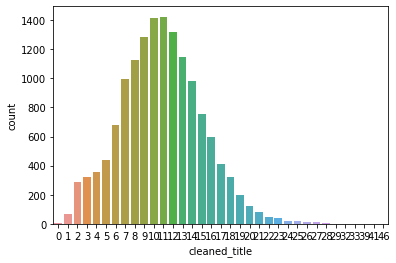

In [77]:
def bar_plot(series):
  df=pd.DataFrame(series)
  sns.countplot(df.columns[0],data=df,norm)
bar_plot(title_lens)  

In [70]:
title_lens_stop=new_df['cleaned_title'].apply(lambda x: str(x)).apply(len_tokens)

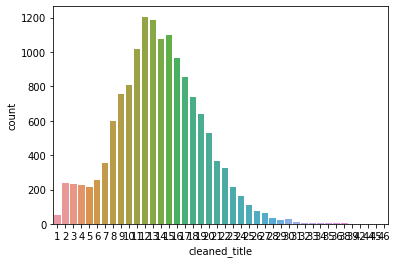

In [71]:
bar_plot(title_lens_stop)

In [73]:
print(title_lens_stop.mean())
print(title_lens_stop.median())
print(title_lens_stop.mode())


13.768848727322894
14.0
0    12
dtype: int64


In [65]:
pd.DataFrame(text_lens)

1716      464
1717      457
1718      352
1719     1422
1720       43
         ... 
14816     129
14817     112
14818     445
14819      51
14820     658
Name: cleaned_text, Length: 14493, dtype: int64

In [47]:
title_lens.shape

(14493,)

In [98]:
exceed=text_lens.iloc[np.where(text_lens.array >512)[0]]

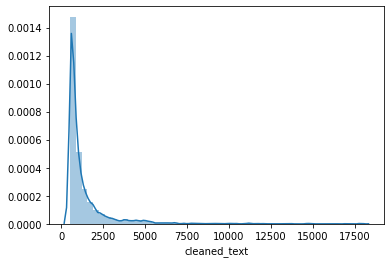

In [101]:
sns.distplot(exceed)

In [87]:
text_lens.describe()

count    14493.000000
mean       681.762782
std       1165.225348
min          2.000000
25%        240.000000
50%        401.000000
75%        663.000000
max      17993.000000
Name: cleaned_text, dtype: float64

In [25]:
def bert_sentence_embedding(text, model):
  cuda=torch.device('cuda')
  twc = ["[CLS] " + txt + " [SEP]" for txt in text]

  # Tokenize the sentence with the BERT tokenizer
  tx = [tokenizer.tokenize(text_with_cls) for text_with_cls in twc]
  
  tt=[]
  for l in tx:
    if len(l)>512:
      tt.append(l[:300]+l[-200:])
    else:
      tt.append(l)  


  # Map the token strings to their vocabulary indeces
  it = [tokenizer.convert_tokens_to_ids(tokenized_text) for tokenized_text in tt]

  # for tup in zip(tokenized_text, indexed_tokens):
    # print('{:<12} {:>6,}'.format(tup[0], tup[1]))

  #token_type_ids to separate one sentence from other
  sids = [[1] * len(tokenized_text) for tokenized_text in tt]

  tokens_tensor = [torch.tensor([indexed_tokens]).to(cuda) for indexed_tokens in it]
  segments_tensors = [torch.tensor([segments_ids]).to(cuda) for segments_ids in sids]

  with torch.no_grad():

    outputs = [model(t_tensor, s_tensors) for t_tensor,s_tensors in zip(tokens_tensor,segments_tensors)]
    # contains outputs of all layers
    hidden_states = [output[2] for output in outputs]

    """
    Current dims:
    [# layers, # batches, # tokens, # features] 
    in our case batches = 1 as only one sentence in being passed
    """
    token_vecs = [hidden_state[-2][0] for hidden_state in hidden_states]

    # Calculate the average of all 22 token vectors.
    sentence_embedding = [(torch.mean(token_vec, dim=0)).unsqueeze(0) for token_vec in token_vecs]

    return torch.cat(sentence_embedding,dim=0)

### Baseline model

In [ ]:
class multimodal(nn.Module):
  def __init__(self,is_cuda,seed,sbert):
    super().__init__()
    # weights for image,text and title with same output dim
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    self.text_weight=nn.Parameter(torch.empty(768,200))
    torch.nn.init.kaiming_normal_(self.text_weight, mode='fan_out', nonlinearity='leaky_relu')
    self.is_cuda=is_cuda
                                                          
    self.img_weight=nn.Parameter(torch.empty(512,200))
    torch.nn.init.kaiming_normal_(self.img_weight, mode='fan_out', nonlinearity='leaky_relu')

    self.fc_1=nn.Linear(400,1)
    # self.fc_2=nn.Linear(300,100)
    # self.fc_3=nn.Linear(100,1)
    self.sig=nn.Sigmoid()

    self.sbert=sbert
    for p in self.sbert.parameters():
      p.requires_grad=False

  def forward(self,img,title,mode='train'):
      img_feature=self.img_feature(img)
      title_feature=self.title_feature(title,self.is_cuda)
      if mode=='eval':
        title_feature.requires_grad=True
        # img_feature.requires_grad=True
      # title_feature.requires_grad=True

      img=torch.mm(img_feature,self.img_weight)
      title=torch.mm(title_feature,self.text_weight)

      combined=torch.cat((img,title),1)

      out=self.fc_1(combined)
      # out=F.relu(self.fc_2(out))
      # out=self.fc_3(out)
      return out,img_feature,title_feature
  def img_feature(self,img):
    # pass img to resnet and extract features.
      img=model_conv.conv1(img)
      img=model_conv.bn1(img)
      img=model_conv.layer1(img)
      img=model_conv.layer2(img)
      img=model_conv.layer3(img)
      img=model_conv.layer4(img)
      img=model_conv.avgpool(img)

      return img.view(img.shape[0],-1)
  def title_feature(self,title,is_cuda):
    # pass text to sbert and extract sentence embeddings.

    feature=torch.tensor(np.array(self.sbert.encode(title)))
    if is_cuda:
      return feature.cuda()
    else:
      return feature  
  def score(self,prediction,actual):
      prediction=self.sig(prediction)
      pred=prediction.squeeze(1).cpu().detach().numpy()
      pred[pred>=0.5]=1
      pred[pred<0.5]=0                                                          
      targ=actual.cpu().numpy()
      f1=f1_score(targ,pred) 
      precision=precision_score(targ,pred)
      return f1,precision

In [ ]:
seed=123    
model=multimodal(is_cuda,seed,sbert_model)  
if is_cuda:
  model.cuda()
  sbert_model.cuda()
  model_conv.cuda()
lr=7e-4
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=0.01)

In [ ]:
checkpoint = torch.load('/content/gdrive/My Drive/ieeebigmm/baseline_2.tar')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
check_point_loss = checkpoint['loss']

In [ ]:
for p in model.sbert.parameters():
  p.requires_grad=False

### babysitting

In [ ]:
first_title=0
first_label=0
first_img=0
for title,(img,label) in zip(train_loader_title,train_loader_img): 
  first_title=title
  first_label=label
  first_img=img
  break


In [ ]:
for i in range(200):
  if is_cuda:
    first_img,first_label=first_img.cuda(),first_label.cuda()
  model.zero_grad()  

  pred=model(first_img,first_title)

  loss=criterion(pred.squeeze(1),first_label)
  loss.backward()

  optimizer.step()  
  if i%20==0:
    f,p=model.score(pred,label)
    print('epoch {} loss={},f1={},precision={}'.format(i,loss.item(),f,p))
     

### Training

In [ ]:
def train_loop(epochs,model,optimizer,criterion,val_every):
  # epochs=5
  train_epoch=[]
  val_epoch=[]
  for e in range(epochs):
    train_loss=[]
    train_f1=[]
    train_precision=[]
    counter=0
    train_batch=[]
    val_batch=[]
    for title,(img,label) in zip(train_loader_title,train_loader_img):            
      counter+=1
      if is_cuda:
        img,label=img.cuda(),label.cuda()         

      model.zero_grad()  

      pred=model(img,title)

      loss=criterion(pred.squeeze(1),label)                                       
      loss.backward()
      
      optimizer.step()
      
      t_f1,t_precision=model.score(pred,label)
      train_loss.append(loss.item())
      train_f1.append(t_f1)                        
      train_precision.append(t_precision)                                      

      if counter%val_every==0:           
        train_batch.append(np.mean(train_loss[-50:]))             
        print('Train loss: {}, train f1: {}, train_precision:{}'.format(np.mean(train_loss[-val_every:]),np.mean(train_f1[-val_every:]),np.mean(train_precision[-val_every:])))            
        model.eval()
        val_f1=[]
        val_loss=[]
        val_precision=[]
        v_c=0
        for title,(img,v_label) in zip(val_loader_title,val_loader_img):
          v_c+=1
          if is_cuda:
            img,v_label=img.cuda(),v_label.cuda()                                 

          v_pred=model(img,title)               

          v_loss=criterion(pred.squeeze(1),label)  
          val_loss.append(v_loss.item())                     

          v_f1,v_precision=model.score(v_pred,v_label)

          val_f1.append(v_f1)
          val_precision.append(v_precision)
          # if v_c==30:
          #   break
        
        print('Epoch {} batch {},val loss={}, val f1 ={}, val_precision={}'.format(e+1,counter,np.mean(val_loss),np.mean(val_f1),np.mean(val_precision)))       
        print('------------------------------------------------------')
        val_batch.append(np.mean(val_loss))
          
        model.train()
    val_epoch.append(np.mean(val_batch))    
    train_epoch.append(np.mean(train_batch))
  return train_epoch,val_epoch
  


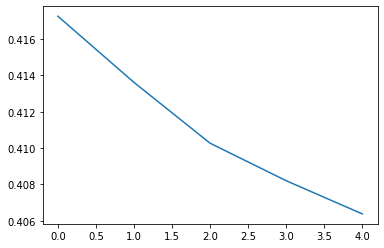

In [ ]:
x=[i for i in range(len(train_epoch))]
plt.plot(x,train_epoch)
plt.show()

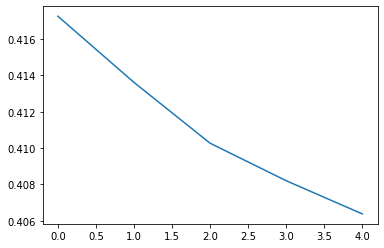

In [ ]:
plt.plot(x,val_epoch)

In [ ]:
train_epoch

[0.41725744398718234,
 0.4136142332669503,
 0.41026793471731554,
 0.408203163620783,
 0.4063757756715252]

In [ ]:
#  torch.save({'model_state_dict':model.state_dict(),'optimizer_state_dict':optimizer.state_dict(),'epoch':10,'loss':0.4,'lr':5e-4,'val_prec':0.844},'/content/gdrive/My Drive/ieeebigmm/baseline_2.tar')

In [ ]:
val_epoch

[0.41725744398718234,
 0.4136142332669503,
 0.41026793471731554,
 0.408203163620783,
 0.4063757756715252]

###Evaluation

In [ ]:
val_f1=[]
val_loss=[]
val_precision=[]
v_c=0
model.eval()
for title,(img,v_label) in zip(val_loader_title,val_loader_img):
  v_c+=1
  if is_cuda:
    img,v_label=img.cuda(),v_label.cuda()                                 

  v_pred=model(img,title)               

  v_loss=criterion(pred.squeeze(1),label)  
  val_loss.append(v_loss.item())                     

  v_f1,v_precision=model.score(v_pred,v_label)

  val_f1.append(v_f1)
  val_precision.append(v_precision)
print(np.mean(val_loss),np.mean(val_f1),np.mean(val_precision))  

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


0.4547621300178005 0.8833054189324175 0.8440408676509691


In [ ]:
model.eval()
t_f=[]
t_prec=[]
t_l=[]
for title,(img,t_label) in zip(test_loader_title,test_loader_img):                                
        if is_cuda:
          img,t_label=img.cuda(),t_label.cuda()                                 

        t_pred=model(img,title)               

        t_loss=criterion(t_pred.squeeze(1),t_label)  
        t_l.append(t_loss.item())                     

        t_f1,t_precision=model.score(t_pred,t_label)
        t_f.append(t_f1)
        t_prec.append(t_precision)
print(np.mean(t_l),np.mean(t_f),np.mean(t_prec))          

0.4192892895002655 0.8920870886110358 0.8564268203684554


### Integrated gradients.

In [12]:
def display_torch(img,channel=None):
  if len(img.shape)==4:
    img=img.squeeze(0)
  if channel=='red':
    img[[1,2],:,:]=0
    img*=0.2
  if channel=='green':
    img[[0,2],:,:]=0
    img*=0.2
  if channel=='blue':
    img[[0,1],:,:]=0
    img*=0.2  
  img=img.permute(1,2,0).detach().cpu().numpy()
  
  pyplot.imshow(img)
sig=nn.Sigmoid()  

In [66]:
class integrated_grads():
  def __init__(self,model,model_conv,sbert_model,model_tok,pad):
      self.model=model
      self.model_conv=model_conv
      
      for p in self.model_conv.parameters():
        p.requires_grad=True
      
      self.cuda=torch.device('cuda')
      self.pad=pad
      self.model_tok=model_tok

      self.sbert_model=sbert_model
      self.orig_sbert_model= SentenceTransformer('bert-base-nli-mean-tokens').to(self.cuda)
      self.orig_state_dict= self.orig_sbert_model.state_dict()
      for p in self.sbert_model.parameters():
        p.requires_grad=True  

      # alphas=torch.arange(0,1,1/3)
      self.sbert_model.load_state_dict(self.orig_state_dict)

      

  def integrated_gradients_text(self,img,title,pad,steps):
    alphas=torch.arange(0,1,1/steps)
    alphas=torch.cat([alphas,torch.tensor([1.])])

    integrated_embeds=[]
    integrated_images=[]
    baseline=(torch.ones(img.shape)*255).to(self.cuda)

    for a in alphas:
      self.sbert_model.state_dict()['0.bert.embeddings.word_embeddings.weight']*=a
      new_img=baseline + (img-baseline)*a

      t_pred,title_feature,img_feature=self.model(new_img,title,'post_hoc')    
      t_pred=sig(t_pred)

      d_img=self.gradient_image(t_pred,img_feature,new_img) 
      importance,toks,d_embeds,tokens=self.gradient_text(title[0],t_pred,title_feature,pad)
      
      integrated_embeds.append(d_embeds)
      integrated_images.append(d_img)

      self.sbert_model.load_state_dict(self.orig_state_dict)

    final=torch.zeros(integrated_embeds[0].shape).to(self.cuda)
    for emb in integrated_embeds:
      final+=emb
    final/=len(integrated_embeds)
    final*= self.orig_sbert_model.state_dict()['0.bert.embeddings.word_embeddings.weight'][tokens]
    final_text_attr=torch.sum(final,dim=1)

    final_img_attr=torch.zeros(integrated_images[0].shape).to(self.cuda)
    for emb in integrated_images:
      final_img_attr+=emb
    final_img_attr/=len(integrated_images)
    final_img_attr*=(img-baseline)

    return final_text_attr,toks,final_img_attr
  def integrated_gradients_image(self,img,title,pad,steps):

    alphas=torch.arange(0,1,1/steps)
    alphas=torch.cat([alphas,torch.tensor([1.])])

    integrated_images=[]
    baseline=(torch.ones(img.shape)*255).to(self.cuda)

    for a in alphas[1:]:
      new_img=baseline + (img-baseline)*a
     
      t_pred,title_feature,img_feature=self.model(img*a,title,'post_hoc')    
      t_pred=sig(t_pred)

      d_img=self.gradient_image(t_pred,img_feature,img*a) 
      
      integrated_images.append(d_img)

    final_img_attr=torch.zeros(integrated_images[0].shape).to(self.cuda)
    for emb in integrated_images:
      final_img_attr+=emb
    final_img_attr/=len(integrated_images)
    final_img_attr*=(img-baseline)
    return final_img_attr      

    
  def gradient_text(self,text,prediction,feature,pad):
    tokens=self.sbert_model.tokenize(text)

    token_dict=self.sbert_model.get_sentence_features(tokens,pad)

    for key in token_dict:
      token_dict[key]=token_dict[key].to(self.cuda)
      
    modules=[]
    for i,module in enumerate(self.sbert_model):
      modules.append(module)  

    for p in modules[0].parameters():
      word_embeddings=p
      break   

    for m in modules:
      token_dict=m(token_dict)

    sentence_embed=token_dict['sentence_embedding']  

    global_grad=self.grad_text_feature(prediction,feature)
    global_grad.requires_grad=True


    d_embeds=torch.autograd.grad(sentence_embed,word_embeddings,global_grad)[0][tokens]
    importance=torch.sum(d_embeds,dim=1)
    toks=self.model_tok.tokenizer.tokenize(text)

    return importance,toks,d_embeds,tokens

  def gradient_image(self,prediction,feature,img):
    img.requires_grad=True

    dz=torch.autograd.grad(prediction,feature,retain_graph=True)[0]

    dz.requires_grad=True

    img_f=self.img_feature(img)  
    
    d_img=torch.autograd.grad(img_f,img,grad_outputs=dz)[0]  

    return d_img
  def img_feature(self,img):
    # pass img to resnet and extract features.
      img=self.model_conv.conv1(img)
      img=self.model_conv.bn1(img)
      img=self.model_conv.layer1(img)
      img=self.model_conv.layer2(img)
      img=self.model_conv.layer3(img)
      img=self.model_conv.layer4(img)
      img=self.model_conv.avgpool(img)

      return img.view(img.shape[0],-1)
  def grad_text_feature(self,prediction,feature):
    global_grad=torch.autograd.grad(prediction,feature)[0]
    return global_grad

  @staticmethod  
  def display_tokens(importance,tokens,normalised=True):
    if normalised:
      importance=2*(importance-importance.min())/(importance.max()-importance.min()) - 1 
    a=[[round(i.item(),2) for i in importance]]
    
    colorscale = [[0, 'red'] ,[0.5,'pink'], [1, 'blue']]
    fig = ff.create_annotated_heatmap(a,x=tokens,y=['attributions'],colorscale=colorscale)
    fig.update_layout(width=800,height=300)
    fig.show()
  @staticmethod
  def display_img_grads(d_img):
    disp=d_img[0,0,:,:]
    disp=2*(disp-disp.min())/(disp.max()-disp.min()) - 1 
    disp=disp.tolist()
    fig=px.imshow(disp)
    fig.update_layout(width=350,height=350)
    fig.show()
    
# ig=integrated_grads(model,model_conv,sbert_model,model_tok,30)

In [ ]:
import time

In [ ]:
min_tok_tn=[]
max_tok_tp=[]
correct_fn=0
counter=0
for i,(img,title,t_label) in enumerate(test_loader):       
  if is_cuda:
    img,t_label=img.cuda(),t_label.cuda()                                 
     
  t_pred,img_feature,title_feature=model(img,title,'eval')             
  t_pred=sig(t_pred)
  if t_pred>=0.5:
    t_pred=1.
  else:
    t_pred=0.  
 
  
  if t_pred==t_label.item() and t_pred==0.:  # correct fake news prediction
    print(i)
    # correct_fn+=1
    # print(correct_fn)
    text_attr,tokens,img_attr=ig.integrated_gradients(img,title,30,60)
    # ig.display_tokens(text_attr,tokens)
    # ig.display_img_grads(img_attr)
    try:
      tok_id=((text_attr==torch.min(text_attr)).nonzero())[0].item() # minimum attribution token. Meaning this causes model to predcit fake news
      tok=tokens[tok_id]
      min_tok_tn.append(tok)
    except ValueError:
      print((text_attr==torch.min(text_attr)).nonzero())  
    # if correct_fn==100:
    #   break      

  if t_pred==t_label.item() and t_pred==1.: # correct real news pred.
    print(i)
    text_attr,tokens,img_attr=ig.integrated_gradients(img,title,30,60)
    try:
      tok_id=((text_attr==torch.max(text_attr)).nonzero())[0].item()
      tok=tokens[tok_id]
      max_tok_tp.append(tok)
    except ValueError:
      print((text_attr==torch.min(text_attr)).nonzero())  
f=open(path+'token_attributions.pkl','wb')
pickle.dump([min_tok_tn,max_tok_tp],f)

###Analyse model

In [69]:
def tokenize_text(text):
  return model_tok.tokenizer.tokenize(text)
def corr_word(word,series):
  presence_word=[]
  for sentence in series:
    presence=int(word in sentence)
    presence_word.append(presence)
  return presence_word 

def pivot_table(word,df,column_name,attr=None):
  #columns of the pivot table.
  # 1. presence of word -(0/1)
  # 2. label of row -(0/1)
  bert_tokens=df[column_name].apply(tokenize_text) 
  presence_vector=corr_word(word,bert_tokens)
  label_vector=df['label'].tolist()
  df=pd.DataFrame(list(zip(presence_vector,label_vector)),columns=[word,'label'])
  df['count']=1
  pivot_df= pd.pivot_table(
    df, 
    values='count', 
    index=[word], 
    columns=['label'], 
    aggfunc=np.size, 
    fill_value=0
  ) 
  fake_news_importance=pivot_df.iloc[1][0]/(piv[0].sum())
  real_news_importance=pivot_df.iloc[1][1]/(piv[1].sum())

  if attr=='min':
    if fake_news_importance>real_news_importance:
      return 1
    else:
      return 0
  if attr=='max':
    if real_news_importance>fake_news_importance:
      return 1
    else:
      return 0        
  

In [83]:
bert_tokenised=cleaned_df['cleaned_title'].apply(tokenize_text)
frame={'bert_tokens':bert_tokenised,'label':cleaned_df['label']}
new_df=pd.DataFrame(frame)
fake_new_df=new_df[new_df['label']==0]
real_new_df=new_df[new_df['label']==1]

In [71]:
fake_new_df.head()

,bert_tokens,label
1717,"[beyonce, jay, z, idea, raising, twins, would,...",0
1718,"[britney, spears, steals, ny, ##e, show, si, #...",0
1721,"[margot, robbie, net, worth]",0
1727,"[irina, shay, ##k, pregnant, bradley, cooper, ...",0
1729,"[blake, shelton, remembers, brother, ', s, dea...",0


In [103]:
fake_news_size=fake_new_df.shape[0]
real_news_size=real_new_df.shape[0]

In [72]:
s=0
for row in fake_new_df['bert_tokens']:
  if 'dealt' in row:
    s+=1
s    

0

In [73]:
def bert_corpus(df):
  all_tokens=[]
  for row in df['bert_tokens']:
    all_tokens+=row
  return all_tokens  

In [74]:
fake_tokens=bert_corpus(fake_new_df)
real_tokens=bert_corpus(real_new_df)

In [111]:
fake_tokens_freq=FreqDist(fake_tokens)
real_tokens_freq=FreqDist(real_tokens)

In [151]:
fake_tokens_freq['colosseum']

0

In [152]:
real_tokens_freq['colosseum']

0

In [106]:
def hypothesis_test(word,mode=None):

  try:
    fake_importance=fake_tokens_freq[word]/fake_news_size
    # fake_importance=fake_tokens_freq[word]/fake_news_size
  except KeyError:
    fake_importance=0
  try:
    real_importance=real_tokens_freq[word]/real_news_size 
  except KeyError:
    real_importance=0
  print(fake_importance,real_importance)  
  if mode=='min':
    if fake_importance>real_importance:
      return 1
    return 0
  if mode=='max':
    if real_importance>fake_importance:
      return 1
    return 0    
  return None    
  

In [204]:
hypothesis_test('justin')

0.06774193548387097 0.013534241631327259


In [ ]:
hypothesis_test('jewish')

0.0008797653958944282 0.0


In [ ]:
fake_news_hypothesis=[hypothesis_test(word,mode='min') for word in min_tok_tn]
sum(fake_news_hypothesis)/len(min_tok_tn)

0.9583333333333334

In [ ]:
real_news_hypothesis=[hypothesis_test(word,mode='max') for word in max_tok_tp]
sum(real_news_hypothesis)/len(max_tok_tp)

0.8293535235876529

In [ ]:
# clustering analysis.
def text_encode(text):
  return sbert_model.encode([text])[0]
# X_train_encoded=X_train['cleaned_title'].apply(sentence_encode)  

In [157]:
f=open(path+'token_attributions.pkl','rb')
min_tok_tn,max_tok_tp=pickle.load(f)
f.close()

In [ ]:
#vocab.
title_tokenized=X_train['cleaned_title'].apply(tokenize_text)

In [ ]:
all_tokens=[]
for row in title_tokenized:
  all_tokens+=row
vocab=list(set(all_tokens))
cluster_words=pd.Series(vocab)

In [ ]:
f=open(path+'train_vocab_encoded.pkl','rb')
vocab_encoded=pickle.load(f)
arr=np.stack(list((vocab_encoded.array)),axis=0)
kmeans = KMeans(n_clusters=4, random_state=0).fit(arr)

In [ ]:
def cluster_predict(word):
  return kmeans.predict([sbert_model.encode([word])[0].tolist()])[0]

In [ ]:
def bar_plot(series):
  x=series.value_counts().index
  y=(((series.value_counts())/series.shape[0])*100).array
  sns.barplot(x,y)

In [ ]:
cluster_min_attr=pd.Series(min_tok_tn).apply(cluster_predict)
cluster_max_attr=pd.Series(max_tok_tp).apply(cluster_predict)

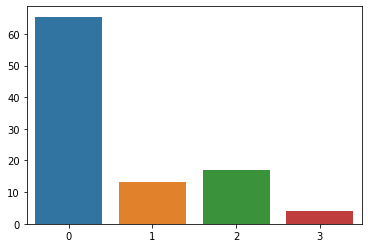

In [ ]:
bar_plot(cluster_min_attr)

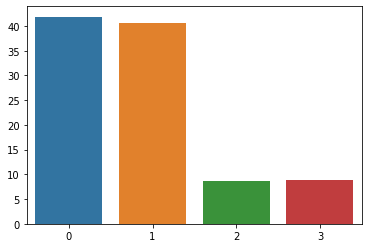

In [ ]:
bar_plot(cluster_max_attr)

In [ ]:
cluster_words.iloc[np.where(kmeans.labels_==0)[0].tolist()]

3            kathy
4            ##rri
7           photos
9           ##dina
10         messing
           ...    
9710         ##oke
9711      hallmark
9714        ##side
9715    surrounded
9722           hub
Length: 3550, dtype: object

In [ ]:
cluster_predict('gossip')

2

In [ ]:
print(len(max_tok_tp))
len(cluster_max_attr)

1717


1717

In [ ]:
((cluster_min_attr.value_counts())/cluster_min_attr.shape[0])*100

0    65.416667
2    17.083333
1    13.333333
3     4.166667
dtype: float64

In [ ]:
((cluster_max_attr.value_counts())/cluster_max_attr.shape[0])*100

0    41.875364
1    40.594059
3     8.794409
2     8.736168
dtype: float64

In [ ]:
# %%time
# vocab_encoded=cluster_words.apply(text_encode)

In [ ]:
# f=open(path+'train_vocab_encoded.pkl','wb')
# pickle.dump(vocab_encoded,f)
# f.close()

In [ ]:
cluster_words.iloc[np.where(kmeans.labels_==0)[0].tolist()]

3          hydra
4       triangle
7            san
9       davidson
10        joanna
          ...   
9710       ringo
9711    designer
9714        gale
9715     rihanna
9722       bafta
Length: 3550, dtype: object

In [ ]:
cluster_predict('angelina',kmeans)

0

In [ ]:
piv=pivot_table('marriage',cleaned_df,'cleaned_title')

In [ ]:
piv

label,0,1
marriage,,
0,3330,10996
1,80,87


In [ ]:
min_attr=pd.Series(min_tok_tn)
min_clusters=min_attr.apply(cluster_predict)

In [ ]:
min_clusters.value_counts()

0    66
2    15
1    14
3     5
dtype: int64

In [ ]:
total=piv.sum().sum()
p_word=(piv.iloc[1].sum())/total
p_word_fail=piv[0][1]/total
p_word_pass=piv[1][1]/total
p_fail_given_word=p_word_fail/p_word


80

In [ ]:
def display_from_folder(i_loc):
  fname=str(X_test.iloc[i_loc].name)+'.png'
  path='/content/gdrive/My Drive/ieeebigmm/images/'+fname
  img=pyplot.imread(path,0)
  pyplot.imshow(img)

### Lightning

In [16]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
import yaml
checkpoint_callback = ModelCheckpoint()

In [17]:
class pretrained():
  @staticmethod
  def img_feature(img):
    img=model_conv.conv1(img)
    img=model_conv.bn1(img)
    img=model_conv.layer1(img)
    img=model_conv.layer2(img)
    img=model_conv.layer3(img)
    img=model_conv.layer4(img)
    img=model_conv.avgpool(img)

    return img.view(img.shape[0],-1)
  @staticmethod
  def text_feature(text,is_cuda):
    feature=torch.tensor(np.array(sbert_model.encode(text)))
    if is_cuda:
      return feature.cuda()
    return feature 

In [18]:
class baseline_lightning(pl.LightningModule):
  def __init__(self,*args,**kwargs):
    
    super().__init__()

    self.hparams=kwargs
    print(kwargs)
    img_dim=kwargs['img_dim']
    text_dim=kwargs['text_dim']

    self.feature_extract=pretrained()
    self.is_cuda=args[0]

    seed_everything(self.is_cuda)

    self.text_weight=nn.Parameter(torch.empty(text_dim,self.hparams.equalise_dim))
    torch.nn.init.kaiming_normal_(self.text_weight, mode='fan_out', nonlinearity='leaky_relu')
                                                          
    self.img_weight=nn.Parameter(torch.empty(img_dim,self.hparams.equalise_dim))
    torch.nn.init.kaiming_normal_(self.img_weight, mode='fan_out', nonlinearity='leaky_relu')

    self.fc_1=nn.Linear(2*self.hparams.equalise_dim,300)
    self.fc_2=nn.Linear(300,100)
    self.fc_3=nn.Linear(100,1)
    self.sig=nn.Sigmoid()
    self.loader_len=args[1]
    self.drop_last=True

  def forward(self,img,text,mode='pre_hoc'):
    img_feature=self.feature_extract.img_feature(img)
    if self.hparams.text_model=='sbert':
      title_feature=self.feature_extract.text_feature(text,self.is_cuda)
    if self.hparams.text_model=='bert':
      title_feature=bert_sentence_embedding(text, bert_model)

    # print(img_feature.shape)
    
    if mode=='post_hoc':
      title_feature.requires_grad=True

    img=torch.mm(img_feature,self.img_weight)
    title=torch.mm(title_feature,self.text_weight)

    combined=torch.cat((img,title),1)

    out=F.relu(self.fc_1(combined))
    out=F.relu(self.fc_2(out))
    out=self.fc_3(out)
    if mode=='post_hoc':
      return out,title_feature,img_feature
    return out
  def bce_loss(self,logits,labels):
    pos_weight=torch.tensor([self.hparams.pos_weight])
    if self.is_cuda:
      pos_weight=pos_weight.cuda()
    return F.binary_cross_entropy_with_logits(logits,labels,pos_weight=pos_weight)

  def training_step(self, train_batch, batch_idx):

    img,text,label=train_batch
    logits=self.forward(img,text)

    loss=self.bce_loss(logits.squeeze(1),label)

    pred=self.logits_to_class(logits)

    # f1=self.metric(pred,label)
    logs = {'train_loss': loss}
    return {'loss': loss, 'log': logs}

  def validation_step(self,val_batch,val_idx): 

    img,text,label=val_batch
    logits=self.forward(img,text)
    loss=self.bce_loss(logits.squeeze(1),label)

    pred=self.logits_to_class(logits)
    # f1=self.metric(pred,label)

    return {'val_loss': loss}

  def validation_epoch_end(self, outputs):

    # called at the end of the validation epoch
    # outputs is an array with what you returned in validation_step for each batch
    # outputs = [{'loss': batch_0_loss}, {'loss': batch_1_loss}, ..., {'loss': batch_n_loss}] 
    avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
    # avg_f1=torch.stack([x['val_f1'] for x in outputs]).mean()

    tensorboard_logs = {'val_loss': avg_loss}
    return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}   

  def test_step(self,test_batch,test_idx):
    img,text,label=val_batch
    logits=self.forward(img,text)
    loss=self.bce_loss(logits.squeeze(1),label)

    pred=self.logits_to_class(logits)
    # f1=self.metric(pred,label)
    return {'test_loss': loss}

  def test_epoch_end(self,outputs):
    avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
    # avg_f1 = torch.stack([x['test_f1'] for x in outputs]).mean()
    tensorboard_logs = {'test_loss': avg_loss}
    return {'avg_test_loss': avg_loss, 'log': tensorboard_logs}  

  def configure_optimizers(self):
    optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.learning_rate,weight_decay=self.hparams.weight_decay)
    scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=self.loader_len, epochs=self.hparams.epochs)
    return [optimizer],[scheduler]   

  def prepare_data(self):  
    path='/content/gdrive/My Drive/ieeebigmm/'
    
    transform = transforms.Compose([transforms.Resize(255),                       
                              transforms.CenterCrop(224),                   
                              transforms.ToTensor()]) 
    
    seed_everything(self.is_cuda)
    self.train_dataset=create_dataset(path,transform,X_train,self.hparams.col_name,'images',y_train)
    self.val_dataset=create_dataset(path,transform,X_val,self.hparams.col_name,'images',y_val)
    self.test_dataset=create_dataset(path,transform,X_test,self.hparams.col_name,'images',y_test)

  def train_dataloader(self):
    return DataLoader(dataset=self.train_dataset, shuffle=True, batch_size=self.hparams.batch_size,drop_last=self.drop_last,num_workers=4,pin_memory=True)
  
  def val_dataloader(self):
    return DataLoader(dataset=self.val_dataset, shuffle=False, batch_size=self.hparams.batch_size,drop_last=self.drop_last,num_workers=4,pin_memory=True)
  def test_dataloader(self):
    return DataLoader(dataset=self.test_dataset, shuffle=False, batch_size=self.hparams.batch_size,drop_last=self.drop_last)  
  def logits_to_class(self,logits):
    logits=self.sig(logits)
    logits[logits>=0.5]=1.
    logits[logits<0.5]=0.  
    return logits
  def score(self,prediction,actual):
      prediction=self.sig(prediction)
      pred=prediction.squeeze(1).cpu().detach().numpy()
      pred[pred>=0.5]=1
      pred[pred<0.5]=0                                                          
      targ=actual.cpu().numpy()
      f1=f1_score(targ,pred) 
      precision=precision_score(targ,pred)
      return f1,precision


In [19]:
img_dim=512
text_dim=768
batch_size=32
lr=6e-4 
weight_decay=1e-4
epochs=10
pos_weight=1.
equalise_dim=200
text_model='sbert'
col_name='cleaned_title'
params={'img_dim':img_dim,'text_dim':text_dim,'batch_size':batch_size,'learning_rate':lr,'weight_decay':weight_decay,'epochs':epochs,'pos_weight':pos_weight,'equalise_dim':equalise_dim,'text_model':text_model,'col_name':col_name}

In [22]:
is_cuda=torch.cuda.is_available()
args=[is_cuda,200]

### Train lightning model

In [40]:
if is_cuda:
  cuda=torch.device('cuda')
  model_conv.to(cuda)
  sbert_model.to(cuda)

In [ ]:
#lr finder.
lightning_model = baseline_lightning(*args,**params)
trainer = Trainer(gpus=1)

# Run learning rate finder
lr_finder = trainer.lr_find(lightning_model)

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()
# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()


In [32]:
# print('Suggested learning rate = {}'.format(new_lr))
new_lr=6e-4

In [34]:
# lightning_model=baseline_lightning(*args,**params)
# t=0
# for param in lightning_model.parameters():
#   t+=param.numel()
# t  

In [41]:
lightning_model=baseline_lightning(*args,**params)
lightning_model.hparams.learning_rate=new_lr
trainer = Trainer(checkpoint_callback=checkpoint_callback,gpus=1,max_epochs=params['epochs'],val_check_interval=0.33,early_stop_callback=True)
trainer.fit(lightning_model)

GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | fc_1 | Linear  | 120 K 
1 | fc_2 | Linear  | 30 K  
2 | fc_3 | Linear  | 101   
3 | sig  | Sigmoid | 0     
INFO:lightning:
  | Name | Type    | Params
---------------------------------
0 | fc_1 | Linear  | 120 K 
1 | fc_2 | Linear  | 30 K  
2 | fc_3 | Linear  | 101   
3 | sig  | Sigmoid | 0     


{'img_dim': 512, 'text_dim': 768, 'batch_size': 32, 'learning_rate': 0.0006, 'weight_decay': 0.0001, 'epochs': 10, 'pos_weight': 1.0, 'equalise_dim': 200, 'text_model': 'sbert', 'col_name': 'cleaned_title'}


FileNotFoundError: ignored

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/version_51/

In [ ]:
# resume from checkpoint.
version='32'

path=os.getcwd()
checkpoint_path=path+'/lightning_logs/version_'+version+'/checkpoints/'+ os.listdir(path+'/lightning_logs/version_'+version+'/checkpoints')[0]

with open(path+'/lightning_logs/version_'+version+'/hparams.yaml') as file:
  param_dict=yaml.load(file, Loader=yaml.FullLoader)
# print(param_dict)
# print(checkpoint_path)
lightning_model=baseline_lightning(*args,**param_dict)
# lightning_model.hparams.learning_rate=new_lr
trainer = Trainer(resume_from_checkpoint=checkpoint_path,checkpoint_callback=checkpoint_callback,gpus=1,max_epochs=params['epochs'],val_check_interval=100,early_stop_callback=True)
trainer.fit(lightning_model)


### testing

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

In [32]:
batch_size=128
path='/content/gdrive/My Drive/ieeebigmm/'
drop_last=False
test_dataset=create_dataset(path,transform,X_test,'cleaned_title','images',y_test)
test_loader= DataLoader(dataset=test_dataset, shuffle=False, batch_size=batch_size,drop_last=drop_last)

In [30]:
version='33'

path=os.getcwd()
checkpoint_path=path+'/lightning_logs/version_'+version+'/checkpoints/'+ os.listdir(path+'/lightning_logs/version_'+version+'/checkpoints')[0]

with open(path+'/lightning_logs/version_'+version+'/hparams.yaml') as file:
  param_dict=yaml.load(file, Loader=yaml.FullLoader)

test_model=baseline_lightning(*args,**param_dict)
checkpoint = torch.load(checkpoint_path, map_location=lambda storage, loc: storage)

test_model.load_state_dict(checkpoint['state_dict'])

if is_cuda:
  test_model=test_model.cuda()
  model_conv=model_conv.cuda()
  sbert_model=sbert_model.cuda()
test_model.eval()    

{'batch_size': 32, 'epochs': 7, 'img_dim': 512, 'learning_rate': 0.0006, 'text_dim': 768, 'weight_decay': 0.0001, 'equalise_dim': 200, 'col_name': 'cleaned_title', 'pos_weight': 1.0, 'text_model': 'sbert'}


baseline_lightning(
  (fc_1): Linear(in_features=400, out_features=300, bias=True)
  (fc_2): Linear(in_features=300, out_features=100, bias=True)
  (fc_3): Linear(in_features=100, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [34]:
sig=nn.Sigmoid()

In [ ]:
final_preds=[]
for i,(img,text,label) in enumerate(test_loader):
#   print(text[62])
#   break
  print(i)
  if is_cuda:
    img,label=img.cuda(),label.cuda()
  with torch.no_grad():
    pred=test_model(img,text)  
    pred=sig(pred)

    pred[pred>=0.5]=1
    pred[pred<0.5]=0

    final_preds.append(pred)

In [36]:
y_pred=(torch.cat(final_preds)).cpu().numpy()
y_true=y_test.to_numpy()

In [37]:
print(('F1 = {}').format(f1_score(y_true,y_pred)))
print(('precision = {}').format(precision_score(y_true,y_pred)))
print(('Accuracy = {}').format(accuracy_score(y_true,y_pred)))
print(('Recall = {}').format(recall_score(y_true,y_pred)))

F1 = 0.8902887139107613
precision = 0.8548387096774194
Accuracy = 0.8250313938886563
Recall = 0.9288061336254108


In [ ]:
F1 = 0.8925577851155703
precision = 0.832306963524396
Accuracy = 0.8229384679782336
Recall = 0.9622124863088719 
# 79 baseline

In [ ]:
F1 = 0.8902887139107613
precision = 0.8548387096774194
Accuracy = 0.8250313938886563
Recall = 0.9288061336254108
# 33 baseline.

In [ ]:
# version 33 is baseline.
# version 26 is visual attention.
# f=open(path+'baseline_scores.pkl','wb')
# pickle.dump([av_f1,av_prec],f)
# f.close()

### attributions

In [ ]:
f=open(path+'baseline_scores.pkl','rb')
av_f1,av_prec=pickle.load(f)
f.close()

In [ ]:
def sample(test_data,sample_size=100):
  # return strtified sample of test data.  

In [38]:
path='/content/gdrive/My Drive/ieeebigmm/'
transform = transforms.Compose([transforms.Resize(255),                       
                                  transforms.CenterCrop(224),                   
                                  transforms.ToTensor()]) 
test_dataset=create_dataset(path,transform,X_test,'cleaned_title','images',y_test)
test_loader= DataLoader(dataset=test_dataset, shuffle=False, batch_size=1,drop_last=False)

In [34]:
def display_torch(img,scale=1,channel=None):
  if len(img.shape)==4:
    img=img.squeeze(0)
  if channel is not None:  
    if channel=='red':
      img[[1,2],:,:]=0
      img*=10
    if channel=='green':
      img[[0,2],:,:]=0
      img*=10
    if channel=='blue':
      img[[0,1],:,:]=0
      img*=10
    img=(img.permute(1,2,0).detach().cpu().numpy())
  if channel is None:
    img=(img.permute(1,2,0).detach().cpu().numpy())*scale
  
  pyplot.imshow(img)

In [67]:
ig=integrated_grads(test_model,model_conv,sbert_model,model_tok,30)
sig=nn.Sigmoid()

In [ ]:
# 20 in tp
# 4 in tn.
# 12 in tn.

In [247]:
tp=0
for i,(img,title,t_label) in enumerate(test_loader):       
  if is_cuda:
    img,t_label=img.cuda(),t_label.cuda()                                 
     
  t_pred,title_feature,img_feature=test_model(img,title,'post_hoc')             
  pred=sig(t_pred)
  if pred>=0.5:
    pred=1.
  else:
    pred=0.  
  
  if pred==t_label.item() and pred==0.:
    # print(i)
    # print(sig(t_pred))
    tp+=1
    if tp==12:
      text_attr,tokens,c_img_attr=ig.integrated_gradients_text(img,title,30,60)
    
      ig.display_tokens(text_attr,tokens,normalised=False)

      # display_torch(c_img_attr,channel=None,scale=5)
      ig.display_img_grads(c_img_attr)

      break
    

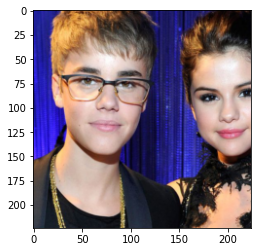

In [245]:
display_torch(img)

In [185]:
_,org,_=test_dataset[25]
org

"janet jackson 's family still mad justin timberlake"

In [ ]:
# replaced mad with celebrate
# replaced stil with not.

In [229]:
def adversary(index):
  img,title,label=test_dataset[index]
  img=img.unsqueeze(0)
  new_title=['janet jackson \'s family not mad logan timberlake']
  if is_cuda:
    img,label=img.cuda(),label.cuda()                                 
     
  t_pred,title_feature,img_feature=test_model(img,new_title,'post_hoc') 
  text_attr,tokens,c_img_attr=ig.integrated_gradients_text(img,new_title,30,60)
  # print(tokens)
  ig.display_tokens(text_attr,tokens,normalised=False)

  print(sig(t_pred).item(),label.item())

In [230]:
adversary(28)

0.6461552381515503 1.0


In [179]:
min_tok_tn[9]

'wants'

In [226]:
max_tok_tp[3]

'fear'

### outer product combine

In [ ]:
class multimodal_outer(nn.Module):
  def __init__(self,is_cuda,seed):
    super().__init__()
    # weights for image,text and title with same output dim
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    self.text_weight=nn.Parameter(torch.empty(768,200))
    torch.nn.init.kaiming_normal_(self.text_weight, mode='fan_out', nonlinearity='leaky_relu')
    self.is_cuda=is_cuda
                                                          
    self.img_weight=nn.Parameter(torch.empty(512,200))
    torch.nn.init.kaiming_normal_(self.img_weight, mode='fan_out', nonlinearity='leaky_relu')

    self.fc_1=nn.Linear(40000,1)

    self.sig=nn.Sigmoid()


  def forward(self,img,title):
      img_feature=self.img_feature(img)
      title_feature=self.title_feature(title,self.is_cuda)

      img=torch.mm(img_feature,self.img_weight).unsqueeze(1)
      title=torch.mm(title_feature,self.text_weight).unsqueeze(1).permute(0,2,1)
      

      cross_prod=title.bmm(img)
      cross_prod=cross_prod.view(cross_prod.shape[0],-1)

      out=self.fc_1(cross_prod)
      return out
  def img_feature(self,img):
    # pass img to resnet and extract features.
      img=model_conv.conv1(img)
      img=model_conv.bn1(img)
      img=model_conv.layer1(img)
      img=model_conv.layer2(img)
      img=model_conv.layer3(img)
      img=model_conv.layer4(img)
      img=model_conv.avgpool(img)

      return img.view(img.shape[0],-1)
  def title_feature(self,title,is_cuda):
    # pass text to sbert and extract sentence embeddings.

    feature=torch.tensor(np.array(sbert_model.encode(title)))
    if is_cuda:
      return feature.cuda()
    else:
      return feature  
  def score(self,prediction,actual):
      prediction=self.sig(prediction)
      pred=prediction.squeeze(1).cpu().detach().numpy()
      pred[pred>=0.5]=1
      pred[pred<0.5]=0                                                          
      targ=actual.cpu().numpy()
      f1=f1_score(targ,pred) 
      precision=precision_score(targ,pred)
      return f1,precision

In [ ]:
seed=123    
model_outer=multimodal_outer(is_cuda,seed)  
if is_cuda:
  model_outer=model_outer.cuda()
  sbert_model=sbert_model.cuda()
  model_conv=model_conv.cuda()
lr=3e-4
pos_weight=torch.tensor([0.75],dtype=float).cuda()
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model_outer.parameters(), lr=lr,weight_decay=0.01)

In [ ]:
checkpoint_outer = torch.load('/content/gdrive/My Drive/ieeebigmm/outer_prod.tar')
model_outer.load_state_dict(checkpoint_outer['model_state_dict'])
optimizer.load_state_dict(checkpoint_outer['optimizer_state_dict'])
train_epoch,val_epoch=checkpoint_outer['train_epoch'],checkpoint_outer['val_epoch']
# check_point_loss = checkpoint['loss']

KeyError: ignored

In [ ]:
for k in checkpoint_outer:
  print(k)

model_state_dict
optimizer_state_dict
epoch
val_loss
train_loss


In [ ]:
model_outer.fc_1.weight

Parameter containing:
tensor([[ 0.0013, -0.0071,  0.0034,  ..., -0.0003, -0.0043, -0.0056]],
       device='cuda:0', requires_grad=True)

In [ ]:
epochs=2
val_every=50
train_epoch,val_epoch=train_loop(epochs,model_outer,optimizer,criterion,val_every)

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Train loss: 0.5306826222391146, train f1: 0.8097813318433505, train_precision:0.810447989863611


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1 batch 50,val loss=0.5034591141957208, val f1 =0.8602035338061169, val_precision=0.8064735341307644
------------------------------------------------------
Train loss: 0.43154201211978943, train f1: 0.8598856675375113, train_precision:0.8307567061418486
Epoch 1 batch 100,val loss=0.3797715553082526, val f1 =0.8716604466203629, val_precision=0.825471257136015
------------------------------------------------------
Train loss: 0.46217262405166365, train f1: 0.8397516359300777, train_precision:0.8250753487383785
Epoch 1 batch 150,val loss=0.46808987492113374, val f1 =0.8471407299806071, val_precision=0.835035133175263
------------------------------------------------------
Train loss: 0.4312802667827782, train f1: 0.8494825654405144, train_precision:0.8260546372561762
Epoch 1 batch 200,val loss=0.5411294027144322, val f1 =0.8662608194983644, val_precision=0.8071361940331848
------------------------------------------------------
Train loss: 0.4196002264582057, train f1: 0.8641693274825

In [ ]:
train_epoch

[0.4466481245341181, 0.36805198307003445]

In [ ]:
val_epoch

[0.41962266197636683, 0.36050544670979434]

In [ ]:
optimizer.state_dict

<bound method Optimizer.state_dict of Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0003
    weight_decay: 0.01
)>

In [ ]:
torch.save({'model_state_dict':model_outer.state_dict(),'optimizer_state_dict':optimizer.state_dict(),'epoch':epochs,'val_loss':val_epoch,'train_loss':train_epoch},'/content/gdrive/My Drive/ieeebigmm/outer_prod.tar')

In [ ]:
torch.manual_seed(1)
x=torch.randn(2,3)
y=torch.randn(2,3)
l=[x,y]


tensor([[-0.8614,  0.6486, -0.9659],
        [ 0.0583, -1.3442, -0.2244]])

### Bert baseline

In [ ]:
!pip install transformers

     |████████████████████████████████| 778kB 5.3MB/s 
     |████████████████████████████████| 3.0MB 28.8MB/s 
     |████████████████████████████████| 1.1MB 54.1MB/s 
     |████████████████████████████████| 890kB 49.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=abe4dd884ce1a5128fdcfe0c1b1fd10e8709c93cd5053754f694a63767727987
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
outputs = model(**inputs, labels=labels)
loss, logits = outputs[:2]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
outputs

(tensor(0.6276, grad_fn=<NllLossBackward>),
 tensor([[0.0751, 0.2109]], grad_fn=<AddmmBackward>))

In [ ]:
# def sbert extract.
